In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad
from torch import tan

INFO  2025-01-08 18:17:15 - pyqtorch: PyQTorch logger successfully setup with log level 20


# Part 1 - Solving the ODE 

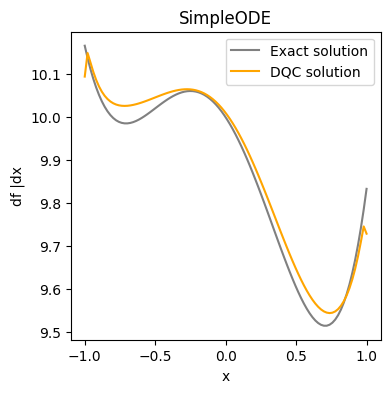

In [19]:
# randomseed
manual_seed(404)
N_QUBITS, DEPTH,LEARNING_RATE, N_POINTS= 6, 20, 0.01, 20
# building the DQC model
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)
# the inputdata is encoded viaa feature map
fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type="Chebyshev")
# choosing acost function
obs = ising_hamiltonian(n_qubits=N_QUBITS)
# building the circuit and the quantum model
circuit = QuantumCircuit(N_QUBITS, chain(fm,ansatz))
model = QNN(circuit=circuit, observable=obs,inputs=["x"])
# using Adamas an optimizer ofchoice
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# define aproblem-specific MSE lossfunction
# for theODE df/dx=4x^3+x^2-2x-1/2
def loss_fn(inputs, outputs):
    dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
    ode_loss = dfdx- (4*(inputs**3) + inputs**2 - 2*inputs - 0.5)
    boundary_loss = model(zeros_like(inputs)) - 10*ones_like(inputs)
    return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean()

# collocationpoints sampling and training
for epoch in range(1000):
    opt.zero_grad()
    # the collocation points are sampledrandomly
    cp = tensor(
    uniform(low=-0.99,high=0.99, size=(N_POINTS,1)), requires_grad=True
    ).float()
    loss = loss_fn(inputs=cp, outputs=model(cp))
    loss.backward()
    opt.step()

# compare the solution to known ground truth
sample_points =linspace(-1.0, 1.0, steps=100).reshape(-1, 1)
# analyticalsolution
analytic_sol =(sample_points**4 + (1 / 3) * sample_points**3 - sample_points**2 - (1 / 2) * sample_points + 10)
# DQC solution
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points.detach().numpy()
# plot
plt.figure(figsize=(4, 4))
plt.plot(x_data,analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data,dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df |dx")
plt.title("SimpleODE")
plt.legend()
plt.show()

# Part 2 - Solving a 2D ODE 